# Figure 1

In [4]:
import statsmodels.api as sm 
import statsmodels.formula.api as smf
import pickle
import pandas as pd
import numpy as np
from psm_causal_effects import psm_causal_effects
from copy import deepcopy

# read data
with open('data.dat', 'rb') as f:
    data, subjects = pickle.load(f)
f.close()

# adding subject ids
for i in range(len(data)):
    data[i]['subject'] = pd.Series(np.repeat(subjects[i],data[i].shape[0],axis=0), index=data[i].index, dtype=str)

del subjects

# within subject normalization
datan = deepcopy(data)
for i in range(len(data)):
    datan[i]['mood'] = (data[i]['mood']-np.nanmean(data[i]['mood']))/np.nanstd(data[i]['mood'])
    datan[i]['mood_prev'] = (data[i]['mood_prev']-np.nanmean(data[i]['mood_prev']))/np.nanstd(data[i]['mood_prev'])
    datan[i]['quality'] = (data[i]['quality']-np.nanmean(data[i]['quality']))/np.nanstd(data[i]['quality'])
    
# concatenatig into a single dataframe
data_all = pd.concat(data, axis=0)
data_all = data_all.reset_index(drop=True)
datan_all = pd.concat(datan, axis=0)
datan_all = datan_all.reset_index(drop=True)

# keeping only relevant variables
data_all = data_all[['subject','mood','mood_prev','quality']]
datan_all = datan_all[['subject','mood','mood_prev','quality']]

# removing nan rows
data_all = data_all.dropna()
data_all = data_all.reset_index(drop=True)
datan_all = datan_all.dropna()
datan_all = datan_all.reset_index(drop=True)

betas_m2s = np.zeros([len(data),2])
betas_s2m = np.zeros([len(data),2])
for iSubj in range(len(data)):
    if data[iSubj].shape[0] ==0:
        betas_m2s[iSubj, :] = np.array([np.nan, np.nan])
        betas_s2m[iSubj, :] = np.array([np.nan, np.nan])
    else:
        md = smf.glm('quality ~ mood_prev', data[iSubj])
        mdf = md.fit()
        betas_m2s[iSubj, :] = mdf.params
        md = smf.glm('mood ~ quality', data[iSubj])
        mdf = md.fit()
        betas_s2m[iSubj, :] = mdf.params

pooled beta = 0.794491104757


/opt/anaconda/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization f

mixed beta = 0.0994168323713
[ 2  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 32 33 35 36 37 38 39 40 41
 42 45 46 47 49 50 52 53] [48  3 31 54 31 54 31 31 31 31 31 31 31 31 55 55 31 43 44 54  3 31 43 43 27
  5  5 48  5 48 31 48 31]


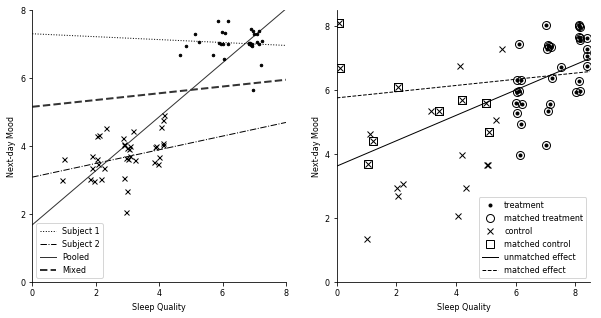

In [18]:
from psm_causal_effects import psm_causal_effects
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

np.random.seed(seed=1)
params = {'font.size' : 8,\
          'axes.labelsize' : 8,\
          'font.style' : 'normal',\
          'font.family' : 'sans-serif',\
        'font.sans-serif' : 'Arial'
}
plt.rcParams.update(params)
noise_amp_mood = 0.05#0.075
noise_amp_quality = 0.15#0.2

ind1 = 74#49
ind2 = 128#149

# removing nan rows
data1 = data[ind1].dropna()
data1 = data1.reset_index(drop=True)
data2 = data[ind2].dropna()
data2 = data2.reset_index(drop=True)

#personal models
plt.figure(figsize=[10, 5])
plt.subplot(121)
plt.plot([0,8], [betas_s2m[ind1, 0]+betas_s2m[ind1,1]*0,betas_s2m[ind1,0]+betas_s2m[ind1,1]*8], linewidth=1, alpha=1, \
         color='black', linestyle=':')
plt.plot([0,8], [betas_s2m[ind2, 0]+betas_s2m[ind2,1]*0,betas_s2m[ind2,0]+betas_s2m[ind2,1]*8], linewidth=1, alpha=1,\
         color='black', linestyle='-.')

data_p  = pd.concat([data1, data2],axis=0)
data_p = data_p[['subject','mood','quality']]

#pooled regression
md = smf.glm('mood ~ quality', data_p)
mdf = md.fit()
plt.plot([0,8], [mdf.params[0],mdf.params[0]+mdf.params[1]*8], color=(.2,.2,.2), linewidth=1, linestyle='-')
print 'pooled beta = '+str(mdf.params[1])

#mixed linear models regression
md = smf.mixedlm('mood ~ quality', data_p, groups=data_p['subject'], re_formula="~quality")
mdf = md.fit() 
plt.plot([0,8], [mdf.params[0],mdf.params[0]+mdf.params[1]*8], color=(.2,.2,.2), linewidth=2, linestyle='--')
print 'mixed beta = '+str(mdf.params[1])

plt.xlabel('Sleep Quality')
plt.ylabel('Next-day Mood')
plt.xlim([0,8])
plt.ylim([0,8])

lgd = plt.legend(['Subject 1','Subject 2','Pooled','Mixed'])

#noise vectors
n_quality_1 = noise_amp_quality*np.random.randn(data1.shape[0])
n_quality_2 = noise_amp_quality*np.random.randn(data2.shape[0])
n_mood_1 = noise_amp_mood*np.random.randn(data1.shape[0])
n_mood_2 = noise_amp_mood*np.random.randn(data2.shape[0])

plt.plot(data1['quality']+n_quality_1,data1['mood']+n_mood_1,'.',markersize=5,\
        markeredgecolor ='black',markerfacecolor='black')

plt.plot(data2['quality']+n_quality_2,data2['mood']+n_mood_2,'.',markersize=5, marker ='x',\
        markeredgecolor ='black',markerfacecolor='black')

plt.ylim([0,8])
plt.xlim([0,8])

ax = plt.gca()
ax.spines['left'].set_position('zero')
# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()
# set the y-spine
ax.spines['bottom'].set_position('zero')
# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

plt.xticks(np.arange(0,9,2));
plt.yticks(np.arange(0,9,2));


## PSM figure
# After publication, only the first and this cell is required
i=111
scorefunction = 'replacement'
output = 'linear'
treatment = 'quality'
outcome = 'mood'
confound = ['dow', 'mean_temp_prev', 'clear_prev', 'act_prev','daytype','stress_prev','energy_prev','focus_prev']
data1 = extract_remove_nans(data[i], [treatment]+[outcome]+confound)
score1, ind_t1, ind_c1 = psm_causal_effects(treatment=data1[treatment], outcome=data1[outcome],\
                                 confound=data1[confound], scorefun=scorefunction, output=output, return_indices=True)
print ind_t1, ind_c1
np.random.seed(seed=101)

noise_amp_mood = 0.05#0.075
noise_amp_quality = 0.2#0.2


plt.subplot(122)

#psm
#score1, ind_t1, ind_c1 = psm_causal_effects(treatment=data1['quality'], outcome=data1['mood'], confound=data1[['mood_prev','stress_prev','daytype','dow','act_prev','quality_prev','mean_temp']], scorefun='replacement', output='difference', return_indices=True)

plt.xlabel('Sleep Quality')
plt.ylabel('Next-day Mood')
plt.xlim([0,8])
plt.ylim([0,8])

#plt.legend(['subject 1','subject 2','pooled','mixed'],bbox_to_anchor=(1.4, 1))

#noise vectors
n_quality = np.abs(noise_amp_quality*np.random.randn(data1[treatment].size))
n_mood = noise_amp_mood*np.random.randn(data1[treatment].size)

case_inds = np.where(data1[treatment]>=np.nanmean(data1[treatment]))[0]
control_inds = np.where(data1[treatment]<np.nanmean(data1[treatment]))[0]

# matched cases and controls
#for i in range(ind_t1.size):
#    plt.plot([data1['quality'][ind_c1[i]]+n_quality[ind_c1[i]], data1['quality'][ind_t1[i]]+n_quality[ind_t1[i]]],\
#             [data1['mood'][ind_c1[i]]+n_mood[ind_c1[i]], data1['mood'][ind_t1[i]]+n_mood[ind_t1[i]]],'-',alpha=.5, \
#             color=(0.5, 0.5, 0.5))


# cases and matched cases
plt.plot(data1['quality'][case_inds]+n_quality[case_inds],data1['mood'][case_inds]+n_mood[case_inds],'.',markersize=6,\
        markeredgecolor =(0,0,0),alpha=1,markerfacecolor=(0,0,0))
plt.plot(data1['quality'][ind_t1]+n_quality[ind_t1],data1['mood'][ind_t1]+n_mood[ind_t1],'o',markersize=8,\
        markeredgecolor =(0,0,0),alpha=1,markerfacecolor="none")


# controls and matched controls
plt.plot(data1['quality'][control_inds]+n_quality[control_inds],data1['mood'][control_inds]+n_mood[control_inds],'x',markersize=6,\
        markeredgecolor =(0, 0, 0),alpha=1,markerfacecolor=(0, 0, 0))
plt.plot(data1['quality'][ind_c1]+n_quality[ind_c1],data1['mood'][ind_c1]+n_mood[ind_c1],'s',markersize=8,\
        markeredgecolor =(0, 0, 0),alpha=1,markerfacecolor="none")

plt.ylim([0,8.5])
plt.xlim([0,8.5])

#remove box

ax = plt.gca()
ax.spines['left'].set_position('zero')

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position('zero')

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()

plt.xticks(np.arange(0,9,2));
plt.yticks(np.arange(0,9,2));

# plot regression lines
md = smf.glm('mood ~ quality', data1)
mdf = md.fit()
betas = mdf.params

plt.plot([0,8.5], [betas[0],betas[0]+betas[1]*8.5], linewidth=1, color =(0,0,0))
#plt.plot([0,8.2], [mdf.params[0],mdf.params[0]+mdf.params[1]*8.2], color=(.2, .2,.2), linewidth=3, alpha=1)

md_matched = smf.glm('mood ~ quality', data1.loc[np.concatenate((ind_t1, ind_c1)),:])
mdf_matched=md_matched.fit()
betas_matched =mdf_matched.params

plt.plot([0,8.5], [betas_matched[0],betas_matched[0]+betas_matched[1]*8.5], linewidth=1, color =(0,0,0), linestyle = '--')

lgd =plt.legend(["treatment","matched treatment", "control", "matched control", "unmatched effect", "matched effect"])

plt.savefig('figures/Fig_1.eps', format='eps', dpi=1200)

plt.savefig('figures/Fig_1.tiff', format='tiff', dpi=1200) 
plt.savefig('figures/Fig_1_small.tiff', format='tiff') 

